In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

import prettytable
import time
import sys
sys.setrecursionlimit(15000)

from PIL import Image
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import random_split

from model410 import FixCapsNet
from images_show import ImageShow

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc= 0.
#defined 
try:
    print(len(test_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list=train_loss_list,
                train_acc_list=train_acc_list,
                test_loss_list=test_loss_list,
                test_acc_list=test_acc_list,
                test_auc_list=test_auc_list,
                val_loss_list=val_loss_list,
                val_acc_list=val_acc_list,
                )

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((308,308)),
                               transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }

In [5]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_path = os.path.abspath(os.path.join(root_path,"skin_lesion"))
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                                      transform=data_transform["val"])
train_num = len(train_dataset)
test_num = len(test_dataset)

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)

BatchSize = 128
T_size = 31
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 10]) 
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,pin_memory=pin_memory,
                                           shuffle=True, num_workers=nw)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,pin_memory=pin_memory,
                                          shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, test_num))

Using 7 types.
Using 10 dataloader workers every process.
using 51699 images for training, 828 images for validation.


In [6]:
# Create capsule network.
conv_outputs = 128 #128_Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6
output_unit_size = 16
img_size = 299
network = FixCapsNet(conv_inputs= n_channels,
                     conv_outputs=conv_outputs,
                     num_primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     output_unit_size=output_unit_size,
                     num_classes=n_classes,
                     init_weights=True,mode="128")

network = network.to(device)
summary(network,(n_channels,img_size,img_size))
# network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 135, 135]         369,024
              ReLU-2        [-1, 128, 135, 135]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(31, 31), stride=(2, 2), bias=False)
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [8]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [9]:
def confusion_matrix(evl_result):

    plt.style.use("seaborn")#classic
    plt.yticks(range(n_classes),cla_dict.values())
    plt.xticks(range(n_classes),cla_dict.values())    
    plt.title("Confusion Matrix")
    plt.imshow(evl_result,cmap=plt.cm.Greens)
    for i in range(len(evl_result)):
        for j in range(len(evl_result[i])):
            plt.text(j,i,int(evl_result[i][j]))

    plt.colorbar()
    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion Matrix.png",dpi=128)

In [10]:
def self_scores(opt="scores"):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']    
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))

    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#
        recal = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#torch.sum(result_table[i])
        F1 = pre * recal * 2 / (pre + recal + 1e-7)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recal, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

In [11]:
# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

In [12]:
def train(epoch):
    network.train()
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    print(f'Epoch: [{epoch}] {img_title} ==> Training ...')
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        
        # target = torch.as_tensor(target, dtype=torch.int64)#for windows

        batch_idx += 1
        target_indices = target
        target_one_hot = to_one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        optimizer.zero_grad()
        output = network(data)

        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        
        loss = network.loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f}, ACC:{:.5f}%".format(batch_idx,len(train_loader),
                                                           loss,
                                                           r_pre/(batch_idx*BatchSize),))
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)    
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    
    print(f'Train_Loss: {epoch_loss},ACC:{round(float(epoch_acc),3)}%')   
    scheduler.step()

In [13]:
def test():
    network.eval()
    global best_acc,evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,tmp_size, Acc=  0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    steps_num = len(test_loader)#len(test_loader) * T_size
    tmp_size = T_size
    print(f'\033[66m{img_title} ==> testing ...\033[0m')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):

            batch_idx +=1
            target_indices = target
            #torch.Size([128, 7]),tensor([[0., 0., 0., 0., 0., 1., 0.],...,[0., 0., 0., 0., 0., 1., 0.]])
            target_one_hot = to_one_hot(target_indices, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
            output = network(data)#torch.Size([batch_size, 7, 16, 1])        
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]  
               
            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = test_num % T_size

            for i in range(tmp_size):
                pred_y = pred.numpy()         
                evl_tmp_result[target_indices[i]][pred[i]] +=1 
    
    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result)   
    accuracy = 100. * float(torch.div(diag_sum,all_sum)) 
    test_acc_list.append(accuracy)
    
    print(f"Test_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")

    if accuracy > best_acc:
        best_acc = accuracy
        evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
        torch.save(network.state_dict(), save_PATH)
        torch.save(evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pt')
        
    print(f'Best_ACC[\033[1;32m{round(float(best_acc),3)}%\033[0m]')

In [14]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: ./tmp/{img_title}/{suf}')
else:
#     !mkdir -p ./tmp/{img_title}/{suf} #linux
    !md E:\Jupyter\woodman\Caps\FixCaps\tmp\{img_title}\{suf} #windows
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
print(save_PATH)

suf:0610_015454
./tmp/HAM10000/0610_015454/best_HAM10000_0610_015454.pth


子目录或文件 #windows 已经存在。
处理: #windows 时出错。


In [15]:
num_epochs = 200

In [16]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()
print('Finished Training')

Epoch: [1] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.45381, ACC:0.16611%
[404/404] Loss0.35907, ACC:0.27123%
Train_Loss: 0.44279162917691883,ACC:0.271%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:58.213%
Best_ACC[58.213%]
Epoch: [2] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.31982, ACC:0.45757%
[404/404] Loss0.33147, ACC:0.47532%
Train_Loss: 0.3426041427520242,ACC:0.475%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.266%
Best_ACC[85.266%]
Epoch: [3] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.31989, ACC:0.51586%
[404/404] Loss0.30012, ACC:0.52027%
Train_Loss: 0.3162578745643691,ACC:0.52%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.749%
Best_ACC[85.749%]
Epoch: [4] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.31646, ACC:0.54773%
[404/404] Loss0.29024, ACC:0.55094%
Train_Loss: 0.29905215665550516,ACC:0.551%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.783%
Best_ACC[85.749%]
Epoch: [5] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.27567, ACC:0.56482%
[404/404] Loss0.29188, ACC:0.56403%
Train_Loss: 0.29043580163823496,ACC:0.564%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.715%
Best_ACC[86.715%]
Epoch: [6] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.28765, ACC:0.56409%
[404/404] Loss0.26921, ACC:0.56656%
Train_Loss: 0.2874802616194333,ACC:0.567%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.594%
Best_ACC[86.715%]
Epoch: [7] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.28121, ACC:0.57654%
[404/404] Loss0.31756, ACC:0.57310%
Train_Loss: 0.28571631965955885,ACC:0.573%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.87%
Best_ACC[86.715%]
Epoch: [8] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.28586, ACC:0.56888%
[404/404] Loss0.26088, ACC:0.57103%
Train_Loss: 0.2869263879290902,ACC:0.571%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.314%
Best_ACC[86.715%]
Epoch: [9] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.32650, ACC:0.57232%
[404/404] Loss0.28923, ACC:0.57321%
Train_Loss: 0.2855691477508828,ACC:0.573%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.435%
Best_ACC[86.715%]
Epoch: [10] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.27522, ACC:0.57449%
[404/404] Loss0.25561, ACC:0.58000%
Train_Loss: 0.28192953038776275,ACC:0.58%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.783%
Best_ACC[86.715%]
Epoch: [11] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25197, ACC:0.58582%
[404/404] Loss0.30773, ACC:0.59207%
Train_Loss: 0.2746907652604698,ACC:0.592%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.749%
Best_ACC[86.715%]
Epoch: [12] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.26513, ACC:0.60644%
[404/404] Loss0.24992, ACC:0.60765%
Train_Loss: 0.26558673964573604,ACC:0.608%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:76.812%
Best_ACC[86.715%]
Epoch: [13] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24219, ACC:0.62369%
[404/404] Loss0.25551, ACC:0.62423%
Train_Loss: 0.2556986235598526,ACC:0.624%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.145%
Best_ACC[86.715%]
Epoch: [14] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25347, ACC:0.63803%
[404/404] Loss0.22354, ACC:0.63763%
Train_Loss: 0.24714718504559877,ACC:0.638%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.56%
Best_ACC[87.56%]
Epoch: [15] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22536, ACC:0.64616%
[404/404] Loss0.20471, ACC:0.64851%
Train_Loss: 0.23973354516495574,ACC:0.649%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.681%
Best_ACC[87.681%]
Epoch: [16] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23605, ACC:0.65223%
[404/404] Loss0.23257, ACC:0.65335%
Train_Loss: 0.23790476176113184,ACC:0.654%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.043%
Best_ACC[88.043%]
Epoch: [17] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22896, ACC:0.65347%
[404/404] Loss0.23116, ACC:0.65443%
Train_Loss: 0.23824163939398113,ACC:0.655%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.99%
Best_ACC[88.043%]
Epoch: [18] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22700, ACC:0.64975%
[404/404] Loss0.23685, ACC:0.64815%
Train_Loss: 0.24127607416398456,ACC:0.648%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.957%
Best_ACC[88.043%]
Epoch: [19] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24433, ACC:0.64287%
[404/404] Loss0.24474, ACC:0.64399%
Train_Loss: 0.24546628072857857,ACC:0.644%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.285%
Best_ACC[88.285%]
Epoch: [20] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24814, ACC:0.64121%
[404/404] Loss0.27060, ACC:0.64059%
Train_Loss: 0.24678545832486437,ACC:0.641%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[89.734%]
Epoch: [21] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23639, ACC:0.63904%
[404/404] Loss0.24637, ACC:0.64049%
Train_Loss: 0.24636975026661806,ACC:0.641%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.246%
Best_ACC[89.734%]
Epoch: [22] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21301, ACC:0.65219%
[404/404] Loss0.19775, ACC:0.65325%
Train_Loss: 0.23962497843964264,ACC:0.653%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[89.734%]
Epoch: [23] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25184, ACC:0.66236%
[404/404] Loss0.24444, ACC:0.66472%
Train_Loss: 0.23338860627448205,ACC:0.665%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.903%
Best_ACC[89.734%]
Epoch: [24] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23492, ACC:0.67729%
[404/404] Loss0.23000, ACC:0.67584%
Train_Loss: 0.22547805419947842,ACC:0.676%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.802%
Best_ACC[89.734%]
Epoch: [25] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22617, ACC:0.68220%
[404/404] Loss0.20925, ACC:0.68562%
Train_Loss: 0.21909468790682235,ACC:0.686%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.406%
Best_ACC[89.734%]
Epoch: [26] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24298, ACC:0.68441%
[404/404] Loss0.22806, ACC:0.68607%
Train_Loss: 0.2179318208726916,ACC:0.686%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.493%
Best_ACC[89.734%]
Epoch: [27] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20029, ACC:0.68557%
[404/404] Loss0.23191, ACC:0.68649%
Train_Loss: 0.21835600783919343,ACC:0.687%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.647%
Best_ACC[89.734%]
Epoch: [28] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23408, ACC:0.67868%
[404/404] Loss0.23144, ACC:0.68038%
Train_Loss: 0.22231632559606346,ACC:0.681%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.507%
Best_ACC[89.734%]
Epoch: [29] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23883, ACC:0.66816%
[404/404] Loss0.24837, ACC:0.67327%
Train_Loss: 0.22782145820484304,ACC:0.673%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[89.734%]
Epoch: [30] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23433, ACC:0.66723%
[404/404] Loss0.25504, ACC:0.66770%
Train_Loss: 0.23076722450037995,ACC:0.668%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.251%
Best_ACC[89.734%]
Epoch: [31] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22448, ACC:0.66441%
[404/404] Loss0.23358, ACC:0.66826%
Train_Loss: 0.22962878740364961,ACC:0.668%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.493%
Best_ACC[89.734%]
Epoch: [32] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20946, ACC:0.67300%
[404/404] Loss0.20047, ACC:0.67435%
Train_Loss: 0.2270810857857808,ACC:0.675%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[91.304%]
Epoch: [33] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22952, ACC:0.68885%
[404/404] Loss0.23853, ACC:0.68655%
Train_Loss: 0.2203769079676949,ACC:0.687%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[91.304%]
Epoch: [34] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19243, ACC:0.69674%
[404/404] Loss0.22021, ACC:0.69773%
Train_Loss: 0.2132733156259107,ACC:0.698%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.319%
Best_ACC[91.304%]
Epoch: [35] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24253, ACC:0.70595%
[404/404] Loss0.18448, ACC:0.70724%
Train_Loss: 0.20737424072357688,ACC:0.707%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[91.304%]
Epoch: [36] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19353, ACC:0.71245%
[404/404] Loss0.20376, ACC:0.70937%
Train_Loss: 0.20608138174998877,ACC:0.71%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.217%
Best_ACC[91.304%]
Epoch: [37] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19703, ACC:0.71159%
[404/404] Loss0.21623, ACC:0.71036%
Train_Loss: 0.20582144534086236,ACC:0.711%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.01%
Best_ACC[91.304%]
Epoch: [38] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18522, ACC:0.70208%
[404/404] Loss0.18012, ACC:0.70069%
Train_Loss: 0.21088565731107597,ACC:0.701%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.821%
Best_ACC[91.304%]
Epoch: [39] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20863, ACC:0.69222%
[404/404] Loss0.19821, ACC:0.69342%
Train_Loss: 0.21547527858378865,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.821%
Best_ACC[91.304%]
Epoch: [40] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23566, ACC:0.68599%
[404/404] Loss0.21161, ACC:0.68640%
Train_Loss: 0.22044416435874334,ACC:0.687%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[91.304%]
Epoch: [41] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22548, ACC:0.68847%
[404/404] Loss0.19604, ACC:0.68632%
Train_Loss: 0.2204587804430192,ACC:0.686%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[91.304%]
Epoch: [42] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.25323, ACC:0.68998%
[404/404] Loss0.20996, ACC:0.69303%
Train_Loss: 0.21630709810127127,ACC:0.693%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.56%
Best_ACC[91.304%]
Epoch: [43] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19560, ACC:0.70289%
[404/404] Loss0.20081, ACC:0.70303%
Train_Loss: 0.2104721176668559,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.063%
Best_ACC[91.304%]
Epoch: [44] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22008, ACC:0.71086%
[404/404] Loss0.20565, ACC:0.71210%
Train_Loss: 0.20474415372061258,ACC:0.712%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[91.787%]
Epoch: [45] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21166, ACC:0.72092%
[404/404] Loss0.20421, ACC:0.71972%
Train_Loss: 0.19885059560437013,ACC:0.72%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[91.787%]
Epoch: [46] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18911, ACC:0.72618%
[404/404] Loss0.19117, ACC:0.72577%
Train_Loss: 0.19794797056382246,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.063%
Best_ACC[91.787%]
Epoch: [47] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20046, ACC:0.71983%
[404/404] Loss0.20835, ACC:0.72295%
Train_Loss: 0.19748411792339665,ACC:0.723%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.01%
Best_ACC[91.787%]
Epoch: [48] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17677, ACC:0.72277%
[404/404] Loss0.18434, ACC:0.71910%
Train_Loss: 0.20113976026820665,ACC:0.719%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[92.391%]
Epoch: [49] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20714, ACC:0.70413%
[404/404] Loss0.21508, ACC:0.70784%
Train_Loss: 0.20786094886831719,ACC:0.708%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[92.391%]
Epoch: [50] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23102, ACC:0.70096%
[404/404] Loss0.22606, ACC:0.70073%
Train_Loss: 0.2125960176091383,ACC:0.701%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.56%
Best_ACC[92.391%]
Epoch: [51] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23373, ACC:0.70746%
[404/404] Loss0.18948, ACC:0.70419%
Train_Loss: 0.21142685715809906,ACC:0.704%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.889%
Best_ACC[92.391%]
Epoch: [52] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21176, ACC:0.70583%
[404/404] Loss0.21584, ACC:0.70546%
Train_Loss: 0.2094826630436548,ACC:0.706%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.285%
Best_ACC[92.391%]
Epoch: [53] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18636, ACC:0.71531%
[404/404] Loss0.23241, ACC:0.71564%
Train_Loss: 0.20389977237670728,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[92.391%]
Epoch: [54] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19453, ACC:0.72343%
[404/404] Loss0.17272, ACC:0.72442%
Train_Loss: 0.19777656464588525,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[92.391%]
Epoch: [55] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20551, ACC:0.73113%
[404/404] Loss0.16324, ACC:0.73281%
Train_Loss: 0.1933583916340134,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[93.72%]
Epoch: [56] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20330, ACC:0.73534%
[404/404] Loss0.17497, ACC:0.73619%
Train_Loss: 0.19067916749875144,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[93.841%]
Epoch: [57] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18130, ACC:0.73608%
[404/404] Loss0.18425, ACC:0.73526%
Train_Loss: 0.19070914660645003,ACC:0.735%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[93.841%]
Epoch: [58] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21460, ACC:0.72931%
[404/404] Loss0.19065, ACC:0.72921%
Train_Loss: 0.19530934357259533,ACC:0.729%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.251%
Best_ACC[93.841%]
Epoch: [59] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19106, ACC:0.72177%
[404/404] Loss0.20549, ACC:0.72090%
Train_Loss: 0.20142351618350143,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[93.841%]
Epoch: [60] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23110, ACC:0.71009%
[404/404] Loss0.20945, ACC:0.71105%
Train_Loss: 0.2065237257076372,ACC:0.711%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[93.841%]
Epoch: [61] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18973, ACC:0.71948%
[404/404] Loss0.23669, ACC:0.71508%
Train_Loss: 0.2058229529769114,ACC:0.715%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[93.841%]
Epoch: [62] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18043, ACC:0.72196%
[404/404] Loss0.19615, ACC:0.71651%
Train_Loss: 0.2035810907214585,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[93.841%]
Epoch: [63] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18966, ACC:0.72258%
[404/404] Loss0.17491, ACC:0.72393%
Train_Loss: 0.19903670837826068,ACC:0.724%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:65.58%
Best_ACC[93.841%]
Epoch: [64] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19103, ACC:0.73000%
[404/404] Loss0.20078, ACC:0.73291%
Train_Loss: 0.1925983907341367,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[93.841%]
Epoch: [65] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16976, ACC:0.73875%
[404/404] Loss0.16945, ACC:0.73942%
Train_Loss: 0.1877136000312201,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[93.841%]
Epoch: [66] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18020, ACC:0.74664%
[404/404] Loss0.19759, ACC:0.74414%
Train_Loss: 0.18567971464726005,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[93.841%]
Epoch: [67] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16608, ACC:0.74671%
[404/404] Loss0.16459, ACC:0.74524%
Train_Loss: 0.18629349059987776,ACC:0.745%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[93.961%]
Epoch: [68] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19384, ACC:0.73813%
[404/404] Loss0.21246, ACC:0.73592%
Train_Loss: 0.19095696649043867,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[93.961%]
Epoch: [69] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17268, ACC:0.73016%
[404/404] Loss0.17903, ACC:0.73010%
Train_Loss: 0.19585078659624156,ACC:0.73%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.836%
Best_ACC[93.961%]
Epoch: [70] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20615, ACC:0.71832%
[404/404] Loss0.19476, ACC:0.71950%
Train_Loss: 0.20140320888840327,ACC:0.72%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[93.961%]
Epoch: [71] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.24506, ACC:0.71631%
[404/404] Loss0.19436, ACC:0.71782%
Train_Loss: 0.20171066550630154,ACC:0.718%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.961%]
Epoch: [72] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22215, ACC:0.72401%
[404/404] Loss0.20628, ACC:0.72471%
Train_Loss: 0.19903706762902806,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.116%
Best_ACC[93.961%]
Epoch: [73] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21839, ACC:0.73356%
[404/404] Loss0.16991, ACC:0.73147%
Train_Loss: 0.1940179888417225,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.169%
Best_ACC[95.169%]
Epoch: [74] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15687, ACC:0.74114%
[404/404] Loss0.21948, ACC:0.74033%
Train_Loss: 0.18835171902238732,ACC:0.741%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.807%
Best_ACC[95.169%]
Epoch: [75] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19491, ACC:0.74807%
[404/404] Loss0.18814, ACC:0.75070%
Train_Loss: 0.18246798235738632,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[95.169%]
Epoch: [76] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18226, ACC:0.75762%
[404/404] Loss0.19006, ACC:0.75350%
Train_Loss: 0.1817261288219159,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.048%
Best_ACC[95.169%]
Epoch: [77] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18143, ACC:0.75336%
[404/404] Loss0.18424, ACC:0.75178%
Train_Loss: 0.18178496144638204,ACC:0.752%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.169%
Best_ACC[95.169%]
Epoch: [78] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19788, ACC:0.74459%
[404/404] Loss0.20451, ACC:0.74350%
Train_Loss: 0.18698296013592494,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.116%
Best_ACC[95.169%]
Epoch: [79] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.23168, ACC:0.73221%
[404/404] Loss0.16969, ACC:0.73573%
Train_Loss: 0.1921062228260654,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.116%
Best_ACC[95.169%]
Epoch: [80] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18380, ACC:0.72815%
[404/404] Loss0.18975, ACC:0.72888%
Train_Loss: 0.1961926914899066,ACC:0.729%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[95.169%]
Epoch: [81] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.21785, ACC:0.72053%
[404/404] Loss0.22038, ACC:0.72633%
Train_Loss: 0.1976405526373056,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[95.169%]
Epoch: [82] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20272, ACC:0.73167%
[404/404] Loss0.21844, ACC:0.73070%
Train_Loss: 0.1952961235869639,ACC:0.731%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[95.169%]
Epoch: [83] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17600, ACC:0.73859%
[404/404] Loss0.20547, ACC:0.73784%
Train_Loss: 0.19072807170819528,ACC:0.738%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.633%
Best_ACC[95.169%]
Epoch: [84] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16513, ACC:0.74791%
[404/404] Loss0.18884, ACC:0.74849%
Train_Loss: 0.18403724927713375,ACC:0.749%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[95.169%]
Epoch: [85] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19150, ACC:0.75398%
[404/404] Loss0.22541, ACC:0.75607%
Train_Loss: 0.17984325215589292,ACC:0.756%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.599%
Best_ACC[95.169%]
Epoch: [86] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16062, ACC:0.75623%
[404/404] Loss0.18122, ACC:0.75652%
Train_Loss: 0.1788846267995858,ACC:0.757%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[95.169%]
Epoch: [87] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14565, ACC:0.75565%
[404/404] Loss0.18718, ACC:0.75611%
Train_Loss: 0.17831527404855974,ACC:0.756%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[95.169%]
Epoch: [88] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17443, ACC:0.75101%
[404/404] Loss0.14879, ACC:0.75072%
Train_Loss: 0.18319414345787302,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.048%
Best_ACC[95.169%]
Epoch: [89] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18577, ACC:0.74292%
[404/404] Loss0.17406, ACC:0.74199%
Train_Loss: 0.18876824981652865,ACC:0.742%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[95.169%]
Epoch: [90] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19288, ACC:0.73430%
[404/404] Loss0.22971, ACC:0.73318%
Train_Loss: 0.19319042972851508,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.599%
Best_ACC[95.169%]
Epoch: [91] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20395, ACC:0.73058%
[404/404] Loss0.19606, ACC:0.73275%
Train_Loss: 0.19439885861212663,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[95.169%]
Epoch: [92] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17624, ACC:0.73426%
[404/404] Loss0.18522, ACC:0.73786%
Train_Loss: 0.19074196674593605,ACC:0.738%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.169%]
Epoch: [93] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19242, ACC:0.74373%
[404/404] Loss0.17293, ACC:0.74433%
Train_Loss: 0.18649130794081356,ACC:0.745%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[95.169%]
Epoch: [94] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17718, ACC:0.75646%
[404/404] Loss0.16666, ACC:0.75514%
Train_Loss: 0.18025300294013308,ACC:0.755%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[95.169%]
Epoch: [95] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18049, ACC:0.76481%
[404/404] Loss0.18674, ACC:0.76209%
Train_Loss: 0.1758545001249502,ACC:0.762%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[95.531%]
Epoch: [96] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18991, ACC:0.75851%
[404/404] Loss0.18892, ACC:0.76002%
Train_Loss: 0.17669044287488012,ACC:0.76%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[95.652%]
Epoch: [97] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18233, ACC:0.76412%
[404/404] Loss0.15444, ACC:0.76303%
Train_Loss: 0.17529446343974311,ACC:0.763%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[95.652%]
Epoch: [98] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19458, ACC:0.75630%
[404/404] Loss0.20211, ACC:0.75642%
Train_Loss: 0.18001075561093813,ACC:0.757%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[95.652%]
Epoch: [99] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18789, ACC:0.74598%
[404/404] Loss0.19026, ACC:0.74772%
Train_Loss: 0.18560081559906502,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.652%]
Epoch: [100] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19953, ACC:0.74045%
[404/404] Loss0.21764, ACC:0.74109%
Train_Loss: 0.1894421732735516,ACC:0.741%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.7%
Best_ACC[95.652%]
Epoch: [101] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19475, ACC:0.74126%
[404/404] Loss0.17875, ACC:0.74010%
Train_Loss: 0.19114421990395772,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.976%
Best_ACC[95.652%]
Epoch: [102] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14950, ACC:0.74281%
[404/404] Loss0.18468, ACC:0.74194%
Train_Loss: 0.18874272464378045,ACC:0.742%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[95.652%]
Epoch: [103] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16734, ACC:0.75062%
[404/404] Loss0.19382, ACC:0.74797%
Train_Loss: 0.185133201134677,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.565%
Best_ACC[95.652%]
Epoch: [104] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16403, ACC:0.75959%
[404/404] Loss0.15942, ACC:0.75915%
Train_Loss: 0.1782217870401864,ACC:0.759%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[95.652%]
Epoch: [105] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18646, ACC:0.77011%
[404/404] Loss0.19451, ACC:0.76634%
Train_Loss: 0.17376230387847022,ACC:0.767%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.807%
Best_ACC[95.652%]
Epoch: [106] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20665, ACC:0.76377%
[404/404] Loss0.18149, ACC:0.76700%
Train_Loss: 0.17314950882060692,ACC:0.767%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.048%
Best_ACC[95.652%]
Epoch: [107] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.13368, ACC:0.76798%
[404/404] Loss0.17570, ACC:0.76622%
Train_Loss: 0.17301372173103954,ACC:0.766%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[95.652%]
Epoch: [108] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16616, ACC:0.76648%
[404/404] Loss0.19854, ACC:0.76365%
Train_Loss: 0.17631454295524868,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.773%
Best_ACC[95.773%]
Epoch: [109] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18101, ACC:0.74927%
[404/404] Loss0.16637, ACC:0.75414%
Train_Loss: 0.1822974890618041,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[95.773%]
Epoch: [110] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18758, ACC:0.74435%
[404/404] Loss0.17471, ACC:0.74476%
Train_Loss: 0.18797535829172277,ACC:0.745%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[95.773%]
Epoch: [111] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18618, ACC:0.74501%
[404/404] Loss0.16858, ACC:0.74304%
Train_Loss: 0.1884237138720432,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:41.787%
Best_ACC[95.773%]
Epoch: [112] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20321, ACC:0.74571%
[404/404] Loss0.16507, ACC:0.74542%
Train_Loss: 0.18645954534116357,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[95.773%]
Epoch: [113] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19519, ACC:0.75182%
[404/404] Loss0.16226, ACC:0.75251%
Train_Loss: 0.18132161566674118,ACC:0.753%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[95.773%]
Epoch: [114] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17647, ACC:0.75975%
[404/404] Loss0.19353, ACC:0.76205%
Train_Loss: 0.17570630586383365,ACC:0.762%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[95.773%]
Epoch: [115] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16485, ACC:0.76682%
[404/404] Loss0.16876, ACC:0.76930%
Train_Loss: 0.17144222148131616,ACC:0.769%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[95.773%]
Epoch: [116] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17176, ACC:0.77433%
[404/404] Loss0.17046, ACC:0.77417%
Train_Loss: 0.16960944670556796,ACC:0.774%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.169%
Best_ACC[95.773%]
Epoch: [117] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14853, ACC:0.76756%
[404/404] Loss0.14601, ACC:0.77121%
Train_Loss: 0.17125126774800886,ACC:0.771%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.169%
Best_ACC[95.773%]
Epoch: [118] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16414, ACC:0.76628%
[404/404] Loss0.19614, ACC:0.76388%
Train_Loss: 0.17516485712315777,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.411%
Best_ACC[95.773%]
Epoch: [119] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16063, ACC:0.75580%
[404/404] Loss0.19940, ACC:0.75851%
Train_Loss: 0.1793913601869994,ACC:0.759%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.773%]
Epoch: [120] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20792, ACC:0.74702%
[404/404] Loss0.20802, ACC:0.74785%
Train_Loss: 0.18585491766876513,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.807%
Best_ACC[95.773%]
Epoch: [121] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17505, ACC:0.74420%
[404/404] Loss0.22733, ACC:0.74638%
Train_Loss: 0.18665844947099686,ACC:0.747%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.014%
Best_ACC[96.014%]
Epoch: [122] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16493, ACC:0.74954%
[404/404] Loss0.17920, ACC:0.74994%
Train_Loss: 0.1849158178314124,ACC:0.75%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[96.014%]
Epoch: [123] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17843, ACC:0.75735%
[404/404] Loss0.17518, ACC:0.75721%
Train_Loss: 0.17937194987541377,ACC:0.757%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[96.014%]
Epoch: [124] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17945, ACC:0.76443%
[404/404] Loss0.18546, ACC:0.76622%
Train_Loss: 0.17359057657125562,ACC:0.766%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[96.014%]
Epoch: [125] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16316, ACC:0.77394%
[404/404] Loss0.16689, ACC:0.77324%
Train_Loss: 0.16908280558810376,ACC:0.773%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.773%
Best_ACC[96.014%]
Epoch: [126] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18709, ACC:0.77147%
[404/404] Loss0.18403, ACC:0.77448%
Train_Loss: 0.16843947642805554,ACC:0.775%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.498%
Best_ACC[96.498%]
Epoch: [127] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17070, ACC:0.77433%
[404/404] Loss0.16617, ACC:0.77363%
Train_Loss: 0.16868444576416866,ACC:0.774%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.048%
Best_ACC[96.498%]
Epoch: [128] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17071, ACC:0.76837%
[404/404] Loss0.16481, ACC:0.76971%
Train_Loss: 0.17311037473823174,ACC:0.77%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.377%
Best_ACC[96.498%]
Epoch: [129] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17829, ACC:0.76373%
[404/404] Loss0.17534, ACC:0.76228%
Train_Loss: 0.1774447896324172,ACC:0.762%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.169%
Best_ACC[96.498%]
Epoch: [130] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.22186, ACC:0.75476%
[404/404] Loss0.19953, ACC:0.75398%
Train_Loss: 0.18233421142443573,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[96.498%]
Epoch: [131] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20668, ACC:0.74733%
[404/404] Loss0.17066, ACC:0.74890%
Train_Loss: 0.1854196763643534,ACC:0.749%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.995%
Best_ACC[96.498%]
Epoch: [132] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18778, ACC:0.75464%
[404/404] Loss0.17993, ACC:0.75284%
Train_Loss: 0.18143621323132278,ACC:0.753%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[96.498%]
Epoch: [133] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18047, ACC:0.76470%
[404/404] Loss0.17517, ACC:0.76348%
Train_Loss: 0.17682085182554652,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[96.498%]
Epoch: [134] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20860, ACC:0.76621%
[404/404] Loss0.17573, ACC:0.76806%
Train_Loss: 0.17203921584947274,ACC:0.768%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[96.498%]
Epoch: [135] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.13705, ACC:0.77599%
[404/404] Loss0.18138, ACC:0.77495%
Train_Loss: 0.16812283656384686,ACC:0.775%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[96.498%]
Epoch: [136] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15140, ACC:0.78125%
[404/404] Loss0.15550, ACC:0.77978%
Train_Loss: 0.16648487211896643,ACC:0.78%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.807%
Best_ACC[96.498%]
Epoch: [137] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16209, ACC:0.77924%
[404/404] Loss0.15173, ACC:0.77852%
Train_Loss: 0.1666840476786146,ACC:0.779%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.928%
Best_ACC[96.498%]
Epoch: [138] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16414, ACC:0.77123%
[404/404] Loss0.17005, ACC:0.77351%
Train_Loss: 0.17051925930646386,ACC:0.774%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.928%
Best_ACC[96.498%]
Epoch: [139] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16925, ACC:0.76535%
[404/404] Loss0.16644, ACC:0.76363%
Train_Loss: 0.17634863465434253,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[96.498%]
Epoch: [140] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17034, ACC:0.75638%
[404/404] Loss0.18146, ACC:0.75646%
Train_Loss: 0.18140019753044195,ACC:0.757%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.063%
Best_ACC[96.498%]
Epoch: [141] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16132, ACC:0.75700%
[404/404] Loss0.17394, ACC:0.75342%
Train_Loss: 0.1830264238068963,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.976%
Best_ACC[96.498%]
Epoch: [142] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16525, ACC:0.75816%
[404/404] Loss0.15373, ACC:0.75832%
Train_Loss: 0.1799516951536188,ACC:0.759%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.014%
Best_ACC[96.498%]
Epoch: [143] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14346, ACC:0.76276%
[404/404] Loss0.19908, ACC:0.76230%
Train_Loss: 0.1763489026908237,ACC:0.762%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[96.498%]
Epoch: [144] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15583, ACC:0.77235%
[404/404] Loss0.18579, ACC:0.77197%
Train_Loss: 0.16948730653465385,ACC:0.772%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[96.498%]
Epoch: [145] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16187, ACC:0.77951%
[404/404] Loss0.17621, ACC:0.77874%
Train_Loss: 0.16563335337703772,ACC:0.779%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.324%
Best_ACC[96.498%]
Epoch: [146] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18099, ACC:0.78311%
[404/404] Loss0.17481, ACC:0.78100%
Train_Loss: 0.16452009649486235,ACC:0.781%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[96.498%]
Epoch: [147] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15652, ACC:0.77877%
[404/404] Loss0.14589, ACC:0.78061%
Train_Loss: 0.1648254899658484,ACC:0.781%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.324%
Best_ACC[96.498%]
Epoch: [148] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15865, ACC:0.77147%
[404/404] Loss0.18156, ACC:0.77529%
Train_Loss: 0.1684795972881931,ACC:0.775%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[96.498%]
Epoch: [149] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16630, ACC:0.76640%
[404/404] Loss0.15642, ACC:0.76367%
Train_Loss: 0.17493054776055977,ACC:0.764%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[96.498%]
Epoch: [150] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18041, ACC:0.76029%
[404/404] Loss0.18311, ACC:0.75955%
Train_Loss: 0.1789347566664219,ACC:0.76%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[96.498%]
Epoch: [151] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15450, ACC:0.75302%
[404/404] Loss0.17557, ACC:0.75474%
Train_Loss: 0.18101950299621808,ACC:0.755%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.029%
Best_ACC[96.498%]
Epoch: [152] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17141, ACC:0.75971%
[404/404] Loss0.20330, ACC:0.76058%
Train_Loss: 0.1789349443509732,ACC:0.761%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[96.498%]
Epoch: [153] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20204, ACC:0.76520%
[404/404] Loss0.14328, ACC:0.76543%
Train_Loss: 0.17426139879787322,ACC:0.766%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.768%
Best_ACC[96.498%]
Epoch: [154] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17026, ACC:0.77355%
[404/404] Loss0.14869, ACC:0.77468%
Train_Loss: 0.16864978293381114,ACC:0.775%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.797%
Best_ACC[96.498%]
Epoch: [155] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14344, ACC:0.78291%
[404/404] Loss0.16784, ACC:0.78048%
Train_Loss: 0.16487203027573552,ACC:0.781%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[96.498%]
Epoch: [156] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17608, ACC:0.78241%
[404/404] Loss0.18260, ACC:0.78481%
Train_Loss: 0.16345321315128614,ACC:0.785%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[96.498%]
Epoch: [157] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19261, ACC:0.78179%
[404/404] Loss0.18743, ACC:0.78297%
Train_Loss: 0.16329271073388582,ACC:0.783%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.029%
Best_ACC[96.498%]
Epoch: [158] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19582, ACC:0.77908%
[404/404] Loss0.16973, ACC:0.77742%
Train_Loss: 0.1669270855254761,ACC:0.778%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[96.498%]
Epoch: [159] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17388, ACC:0.77154%
[404/404] Loss0.17214, ACC:0.76882%
Train_Loss: 0.17341020802902704,ACC:0.769%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[96.498%]
Epoch: [160] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17968, ACC:0.76013%
[404/404] Loss0.18760, ACC:0.75837%
Train_Loss: 0.17829001691229274,ACC:0.759%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.99%
Best_ACC[96.498%]
Epoch: [161] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17250, ACC:0.76141%
[404/404] Loss0.18877, ACC:0.75996%
Train_Loss: 0.17878821193434224,ACC:0.76%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.319%
Best_ACC[96.498%]
Epoch: [162] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15197, ACC:0.75832%
[404/404] Loss0.16872, ACC:0.76044%
Train_Loss: 0.17738428582796956,ACC:0.761%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.797%
Best_ACC[96.498%]
Epoch: [163] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20126, ACC:0.77166%
[404/404] Loss0.17826, ACC:0.76940%
Train_Loss: 0.17212934131817062,ACC:0.77%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.164%
Best_ACC[96.498%]
Epoch: [164] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16970, ACC:0.77611%
[404/404] Loss0.15896, ACC:0.77653%
Train_Loss: 0.16720517208375554,ACC:0.777%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.13%
Best_ACC[96.498%]
Epoch: [165] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16580, ACC:0.78218%
[404/404] Loss0.15107, ACC:0.78355%
Train_Loss: 0.1629074321746236,ACC:0.784%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.164%
Best_ACC[96.498%]
Epoch: [166] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.11721, ACC:0.79080%
[404/404] Loss0.15519, ACC:0.78763%
Train_Loss: 0.16102497180057043,ACC:0.788%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.043%
Best_ACC[96.498%]
Epoch: [167] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15827, ACC:0.78233%
[404/404] Loss0.16070, ACC:0.78398%
Train_Loss: 0.16236074396067918,ACC:0.784%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[96.498%]
Epoch: [168] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17416, ACC:0.78117%
[404/404] Loss0.13440, ACC:0.77910%
Train_Loss: 0.16620699899031385,ACC:0.779%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.937%
Best_ACC[96.498%]
Epoch: [169] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14123, ACC:0.77247%
[404/404] Loss0.21346, ACC:0.77232%
Train_Loss: 0.17194341305680205,ACC:0.773%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[96.498%]
Epoch: [170] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17302, ACC:0.76787%
[404/404] Loss0.17138, ACC:0.76771%
Train_Loss: 0.1744729407721817,ACC:0.768%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.42%
Best_ACC[96.498%]
Epoch: [171] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15425, ACC:0.76767%
[404/404] Loss0.14910, ACC:0.76470%
Train_Loss: 0.17582006376273562,ACC:0.765%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[96.498%]
Epoch: [172] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.20980, ACC:0.76412%
[404/404] Loss0.15401, ACC:0.76319%
Train_Loss: 0.1756916297323043,ACC:0.763%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.44%
Best_ACC[96.498%]
Epoch: [173] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18600, ACC:0.76961%
[404/404] Loss0.18001, ACC:0.77201%
Train_Loss: 0.17066315502518475,ACC:0.772%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.454%
Best_ACC[96.498%]
Epoch: [174] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15378, ACC:0.78075%
[404/404] Loss0.14974, ACC:0.78171%
Train_Loss: 0.16493005132173547,ACC:0.782%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.126%
Best_ACC[96.498%]
Epoch: [175] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18813, ACC:0.78481%
[404/404] Loss0.16418, ACC:0.78721%
Train_Loss: 0.16065084281386716,ACC:0.787%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.454%
Best_ACC[96.498%]
Epoch: [176] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.13955, ACC:0.78566%
[404/404] Loss0.14817, ACC:0.78899%
Train_Loss: 0.15948852072331574,ACC:0.789%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.729%
Best_ACC[96.498%]
Epoch: [177] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.13967, ACC:0.78782%
[404/404] Loss0.17038, ACC:0.78752%
Train_Loss: 0.16078187202536823,ACC:0.788%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.99%
Best_ACC[96.498%]
Epoch: [178] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16824, ACC:0.78040%
[404/404] Loss0.15305, ACC:0.77934%
Train_Loss: 0.16614099248948663,ACC:0.78%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.473%
Best_ACC[96.498%]
Epoch: [179] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16910, ACC:0.77297%
[404/404] Loss0.17238, ACC:0.77224%
Train_Loss: 0.17042763400269617,ACC:0.772%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:77.899%
Best_ACC[96.498%]
Epoch: [180] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16656, ACC:0.76547%
[404/404] Loss0.20864, ACC:0.76609%
Train_Loss: 0.1743889647618969,ACC:0.766%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.802%
Best_ACC[96.498%]
Epoch: [181] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16248, ACC:0.76373%
[404/404] Loss0.16596, ACC:0.76501%
Train_Loss: 0.17527088401193666,ACC:0.765%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:78.14%
Best_ACC[96.498%]
Epoch: [182] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17301, ACC:0.77166%
[404/404] Loss0.16355, ACC:0.76978%
Train_Loss: 0.1731323650346534,ACC:0.77%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[96.498%]
Epoch: [183] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17789, ACC:0.77479%
[404/404] Loss0.17443, ACC:0.77402%
Train_Loss: 0.16967982632836492,ACC:0.774%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[96.498%]
Epoch: [184] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19405, ACC:0.78469%
[404/404] Loss0.15942, ACC:0.78446%
Train_Loss: 0.1635885736582303,ACC:0.785%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:78.019%
Best_ACC[96.498%]
Epoch: [185] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.11490, ACC:0.78891%
[404/404] Loss0.15000, ACC:0.78846%
Train_Loss: 0.1597907601643612,ACC:0.789%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.164%
Best_ACC[96.498%]
Epoch: [186] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18286, ACC:0.78972%
[404/404] Loss0.14733, ACC:0.78804%
Train_Loss: 0.15974848568070643,ACC:0.788%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.957%
Best_ACC[96.498%]
Epoch: [187] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16628, ACC:0.79467%
[404/404] Loss0.19591, ACC:0.79080%
Train_Loss: 0.15896554868483898,ACC:0.791%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.386%
Best_ACC[96.498%]
Epoch: [188] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16020, ACC:0.78272%
[404/404] Loss0.13847, ACC:0.78438%
Train_Loss: 0.16301849655954553,ACC:0.785%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.522%
Best_ACC[96.498%]
Epoch: [189] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16392, ACC:0.77746%
[404/404] Loss0.16864, ACC:0.77574%
Train_Loss: 0.16880853959165587,ACC:0.776%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.937%
Best_ACC[96.498%]
Epoch: [190] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18532, ACC:0.77073%
[404/404] Loss0.18430, ACC:0.76998%
Train_Loss: 0.17211281220511634,ACC:0.77%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:75.242%
Best_ACC[96.498%]
Epoch: [191] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.19519, ACC:0.77417%
[404/404] Loss0.16613, ACC:0.76955%
Train_Loss: 0.1741252706413812,ACC:0.77%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:74.758%
Best_ACC[96.498%]
Epoch: [192] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16044, ACC:0.76926%
[404/404] Loss0.18085, ACC:0.76870%
Train_Loss: 0.1724204952173894,ACC:0.769%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:79.831%
Best_ACC[96.498%]
Epoch: [193] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.14315, ACC:0.77572%
[404/404] Loss0.16102, ACC:0.77599%
Train_Loss: 0.16806644678927293,ACC:0.776%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.937%
Best_ACC[96.498%]
Epoch: [194] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.12931, ACC:0.78322%
[404/404] Loss0.19881, ACC:0.78396%
Train_Loss: 0.1632835540441003,ACC:0.784%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:68.72%
Best_ACC[96.498%]
Epoch: [195] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.16636, ACC:0.79165%
[404/404] Loss0.14548, ACC:0.79262%
Train_Loss: 0.1579852098469982,ACC:0.793%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.024%
Best_ACC[96.498%]
Epoch: [196] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17421, ACC:0.79196%
[404/404] Loss0.13528, ACC:0.79370%
Train_Loss: 0.15711533634158054,ACC:0.794%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[96.498%]
Epoch: [197] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.15674, ACC:0.79073%
[404/404] Loss0.19132, ACC:0.79133%
Train_Loss: 0.15764097338265712,ACC:0.792%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.662%
Best_ACC[96.498%]
Epoch: [198] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17369, ACC:0.78953%
[404/404] Loss0.16297, ACC:0.78742%
Train_Loss: 0.1610884369526169,ACC:0.788%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.126%
Best_ACC[96.498%]
Epoch: [199] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.18269, ACC:0.78284%
[404/404] Loss0.18437, ACC:0.78160%
Train_Loss: 0.16565062861778948,ACC:0.782%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.251%
Best_ACC[96.498%]
Epoch: [200] HAM10000 ==> Training ...


  0%|          | 0/404 [00:00<?, ?it/s]

[202/404] Loss0.17189, ACC:0.76980%
[404/404] Loss0.16059, ACC:0.77176%
Train_Loss: 0.1712784629388906,ACC:0.772%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.28%
Best_ACC[96.498%]
Finished Training


In [17]:
show.conclusion(img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [126]
[Test]  ACC:96.5%.


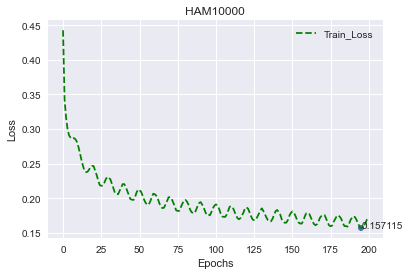

In [18]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

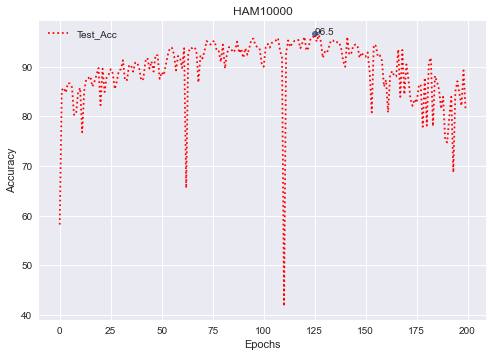

In [19]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [20]:
network.load_state_dict(torch.load(save_PATH))
for i in range(5):
    test()

HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.498%
Best_ACC[96.498%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.498%
Best_ACC[96.498%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.498%
Best_ACC[96.498%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.498%
Best_ACC[96.498%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.498%
Best_ACC[96.498%]


In [21]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.9091  |  0.87  | 0.889 |          |
|  bcc   |   0.7742  | 0.923  | 0.842 |          |
|  bkl   |   0.875   | 0.848  | 0.862 |          |
|   df   |    0.6    |  0.5   | 0.545 |          |
|  mel   |   0.8889  | 0.941  | 0.914 |          |
|   nv   |   0.9924  | 0.988  |  0.99 |          |
|  vasc  |    0.9    |  0.9   |  0.9  |          |
| Total: |           |        |       |  0.965   |
+--------+-----------+--------+-------+----------+


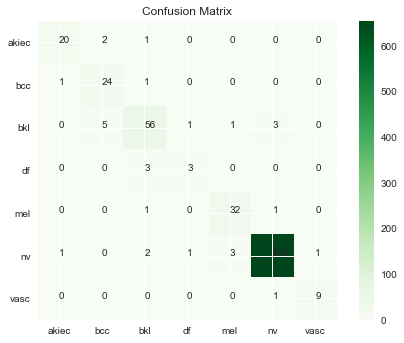

In [22]:
confusion_matrix(evl_result)

In [23]:
# #save
s1 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s1)
s2 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s2)

In [ ]:
torch.cuda.memory.empty_cache()